# Предсказание стоимости жилья

В проекте нам нужно обучить две модели линейной регрессии на данных о жилье в Калифорнии в 1990 году. В столбцах файла `housing.csv` содержатся следующие данные:
* `longitude` — широта;
* `latitude` — долгота;
* `housing_median_age` — медианный возраст жителей жилого массива;
* `total_rooms` — общее количество комнат в домах жилого массива;
* `total_bedrooms` — общее количество спален в домах жилого массива;
* `population` — количество человек, проживающих в жилом массиве;
* `households` — количество домохозяйств в жилом массиве;
* `median_income` — медианный доход жителей жилого массива;
* `median_house_value` — медианная стоимость дома в жилом массиве (целевой признак);
* `ocean_proximity` — близость к океану.

На основе этих данных нам нужно предсказать медианную стоимость дома в жилом массиве — `median_house_value`. Для оценки качества модели по условиям задания мы будем использовать метрики RMSE, MAE и R2.

## Подготовка данных

Прежде чем переходить к дданным, выполним необходимые импорты.

In [1]:
import pandas as pd
import pyspark
import pyspark.sql.functions as F

import seaborn as sns

from matplotlib import pyplot as plt


from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import Bucketizer, Imputer, OneHotEncoder, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, StringType

try:
    import phik
except ModuleNotFoundError:
    !pip install phik -q
    import phik

Для нашего проекта мы создадим случайный ключ, инициализируем сессию и загрузим данные из файла `housing.csv`. На основе описания каждого столбца мы видим, что информация в столбцах, представляющих количественные переменные, не может быть равна нулю.

In [2]:
RANDOM_SEED = 2222

spark = (
    SparkSession.builder
    .master("local")
    .appName("Cali Housing Value")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)

df = spark.read.csv(
    "/datasets/housing.csv",
    inferSchema=True,
    header=True
)

Взглянем на загруженные данные.

In [3]:
df.show(n=5, truncate=False, vertical=True)
df.printSchema()
df.describe().show(truncate=False, vertical=True)

-RECORD 0----------------------
 longitude          | -122.23  
 latitude           | 37.88    
 housing_median_age | 41.0     
 total_rooms        | 880.0    
 total_bedrooms     | 129.0    
 population         | 322.0    
 households         | 126.0    
 median_income      | 8.3252   
 median_house_value | 452600.0 
 ocean_proximity    | NEAR BAY 
-RECORD 1----------------------
 longitude          | -122.22  
 latitude           | 37.86    
 housing_median_age | 21.0     
 total_rooms        | 7099.0   
 total_bedrooms     | 1106.0   
 population         | 2401.0   
 households         | 1138.0   
 median_income      | 8.3014   
 median_house_value | 358500.0 
 ocean_proximity    | NEAR BAY 
-RECORD 2----------------------
 longitude          | -122.24  
 latitude           | 37.85    
 housing_median_age | 52.0     
 total_rooms        | 1467.0   
 total_bedrooms     | 190.0    
 population         | 496.0    
 households         | 177.0    
 median_income      | 7.2574   
 median_

Видно, что в столбце `total_bedrooms` имеются пропуски.

Посмотрим на уникальные значения в столбце `ocean_proximity`.

In [4]:
df.groupBy(
    "ocean_proximity"
).agg(
    F.count(
        "ocean_proximity"
    ).alias(
        "count"
    )
).toPandas()

,ocean_proximity,count
0,ISLAND,5
1,NEAR OCEAN,2658
2,NEAR BAY,2290
3,<1H OCEAN,9136
4,INLAND,6551


Калифорния все же материковая часть континента, ошибку в наименовани истолбца исправим.

In [5]:
df = df.replace("ISLAND", "INLAND")

Посмотрим, есть ли в датафрейме полные дубликаты.

In [6]:
print(df.exceptAll(df.dropDuplicates()).count())

0


Полные дубликаты отсутвуют. Отлично.

Построим гистограммы и диагарммы размаха для числовых признаков в датафрейме.

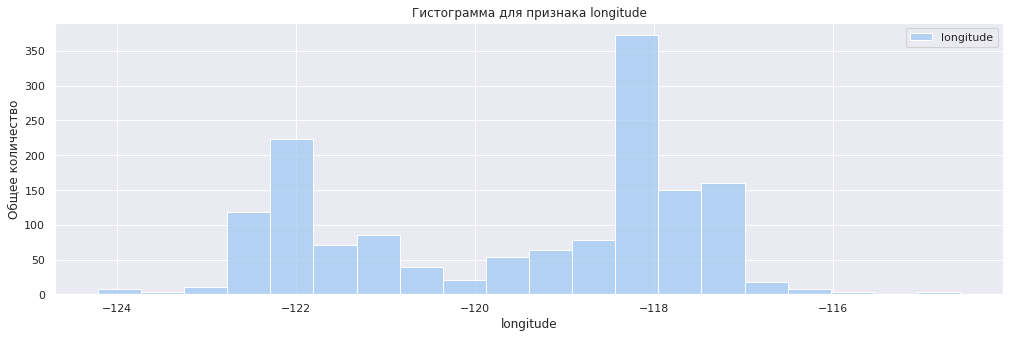

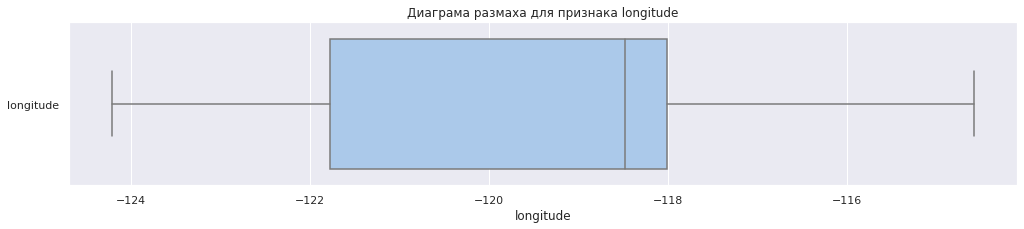

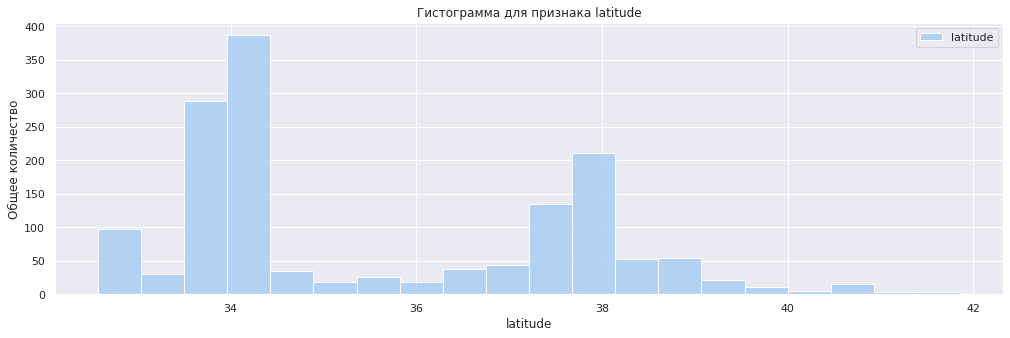

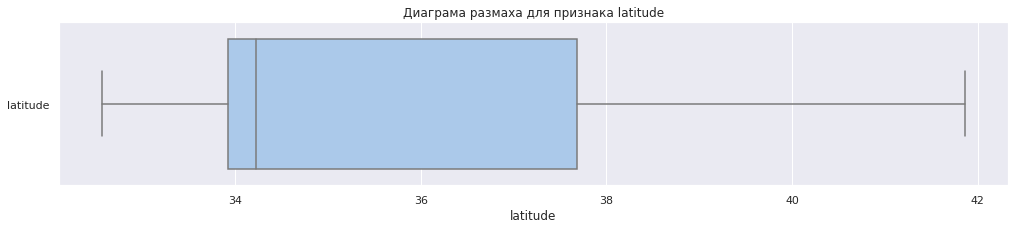

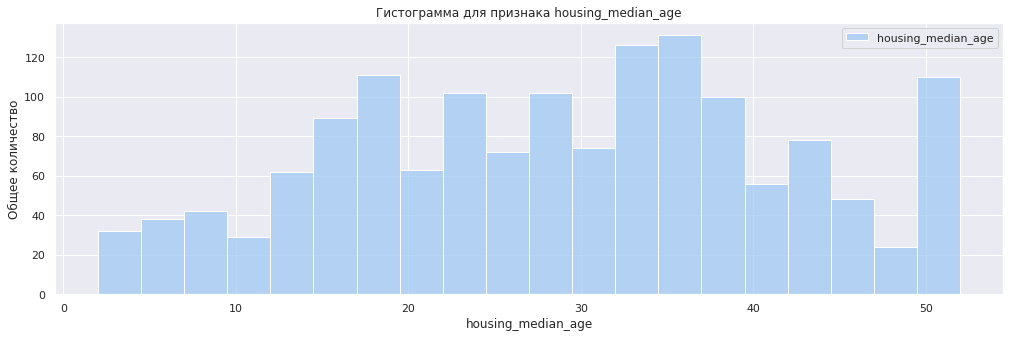

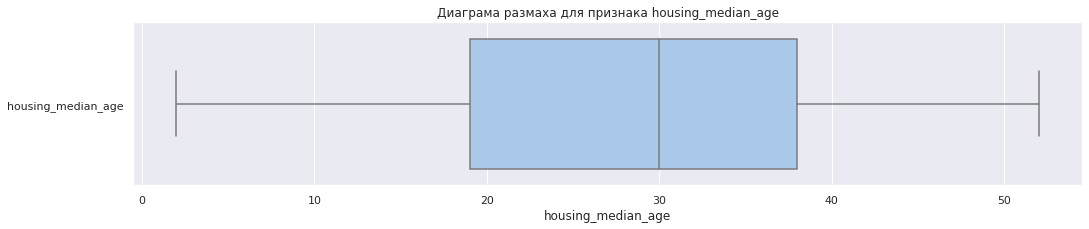

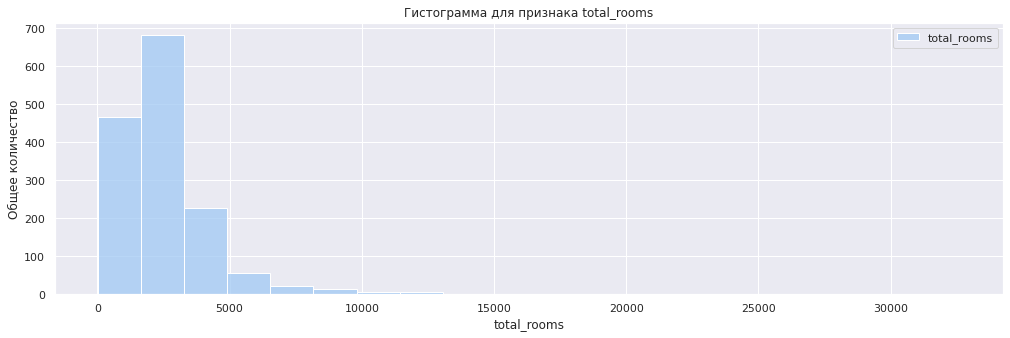

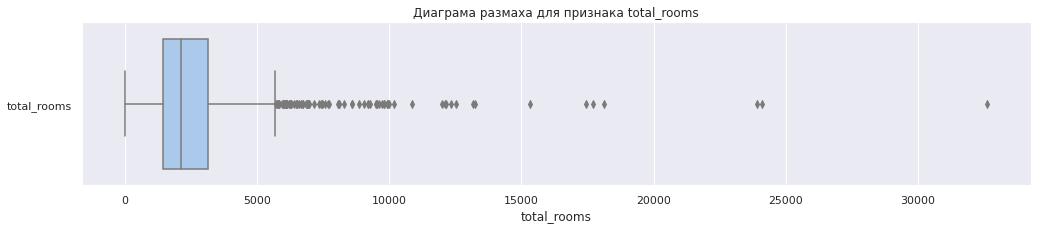

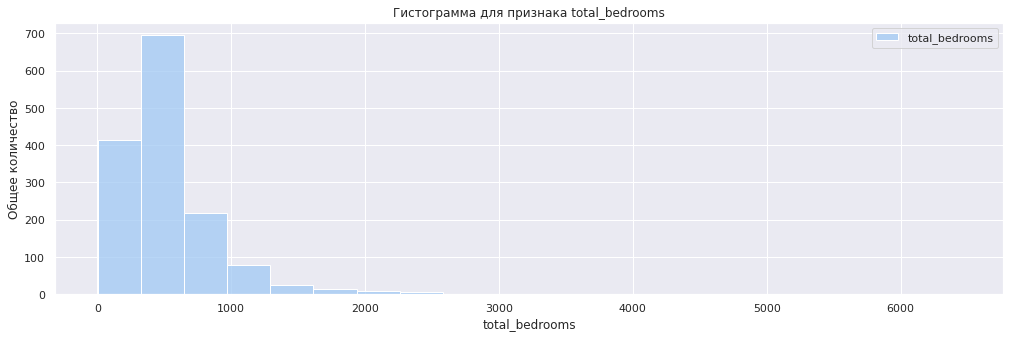

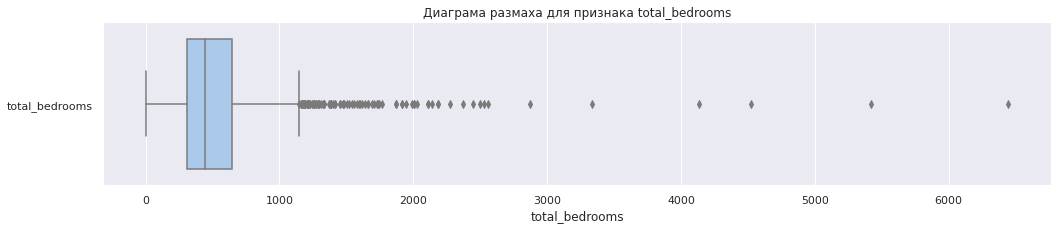

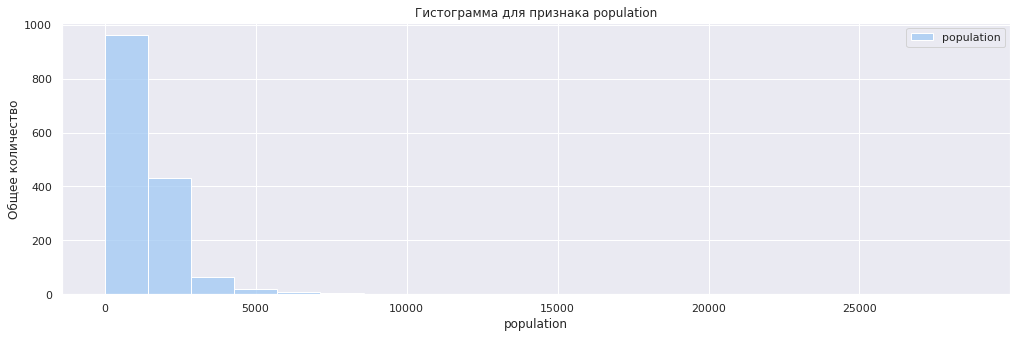

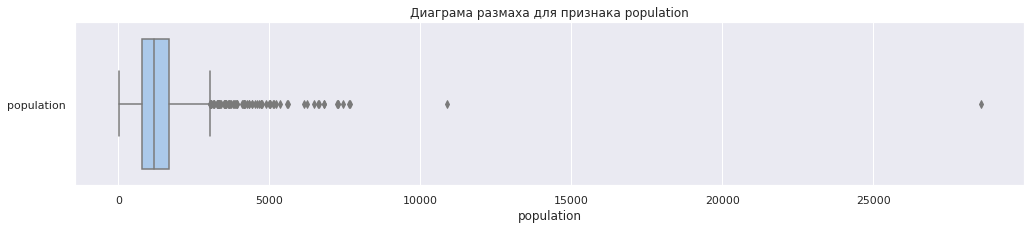

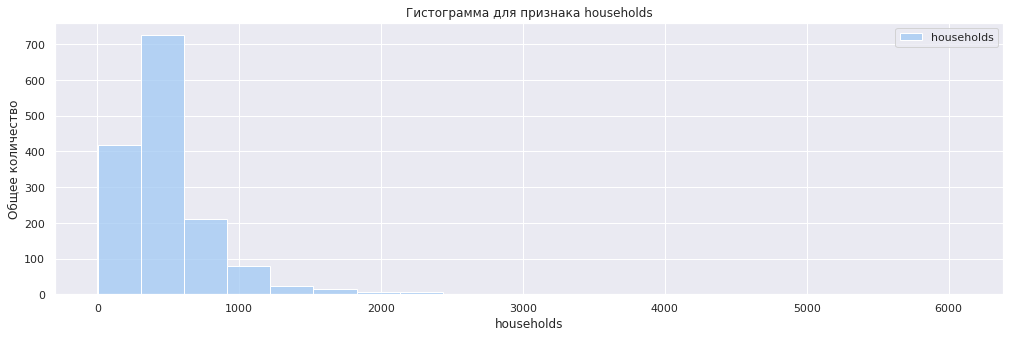

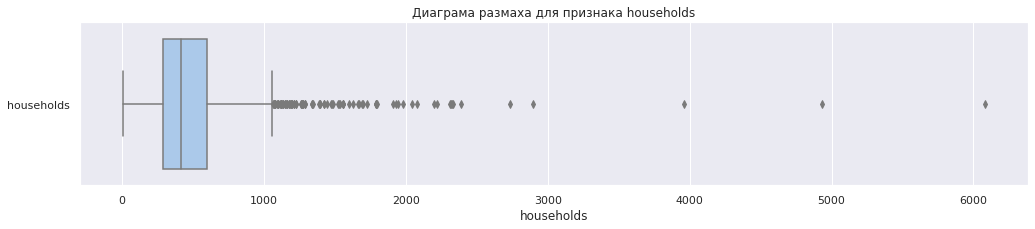

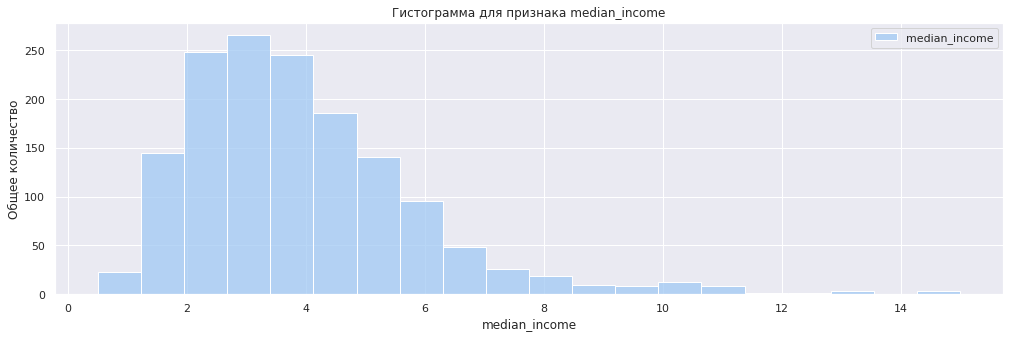

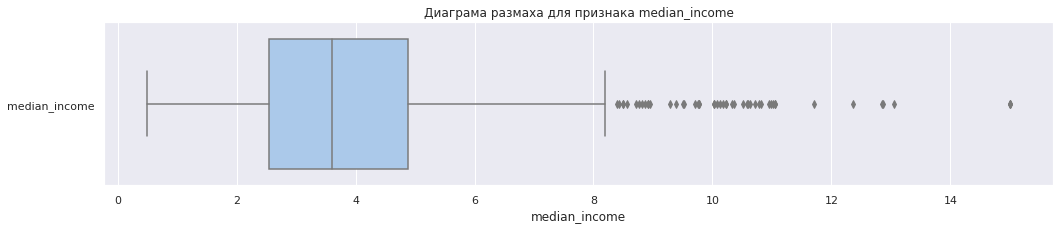

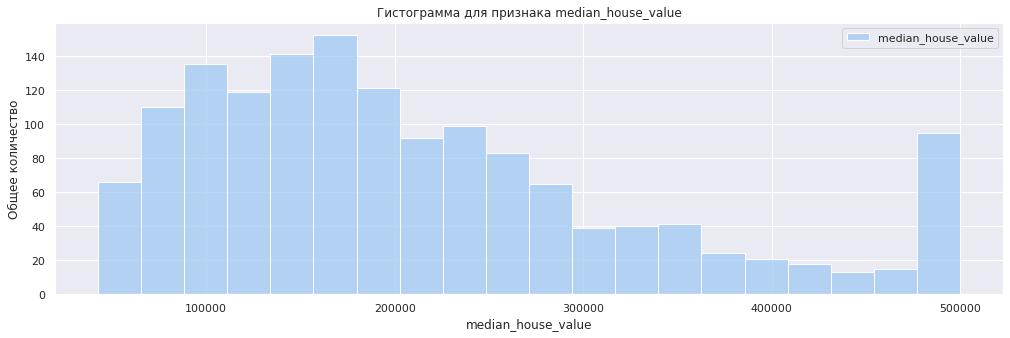

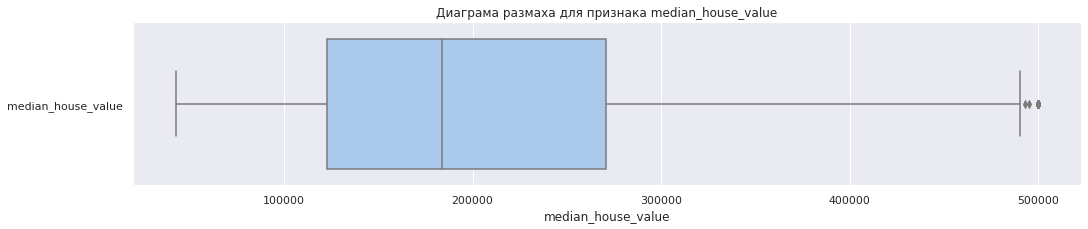

In [7]:
features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    "median_house_value"
    ]

for feature in features:
    plt.figure(figsize=(17, 5))
    sns.set_theme(palette="pastel")
    sns.histplot(
        df.select(feature).sample(.075, seed=RANDOM_SEED).toPandas(),
        bins = 20
    ).set(
        title = f"Гистограмма для признака {feature}",
        xlabel = feature,
        ylabel = 'Общее количество')

    plt.figure(figsize=(17, 3))
    sns.boxplot(
        data=df.select(feature).sample(.075, seed=RANDOM_SEED).toPandas(), 
        orient='h'
    ).set(
        title = f"Диаграма размаха для признака {feature}",
        xlabel = feature,
        )
    plt.show()

Как видно из графиков, большинство признаков имеют выбросы. Так как выбросы присутствуют во многих столбцах и они имеют схожий характер, получается на аномалия, а стутра данных.

Рассмотрим матрицу корреляции между переменными.

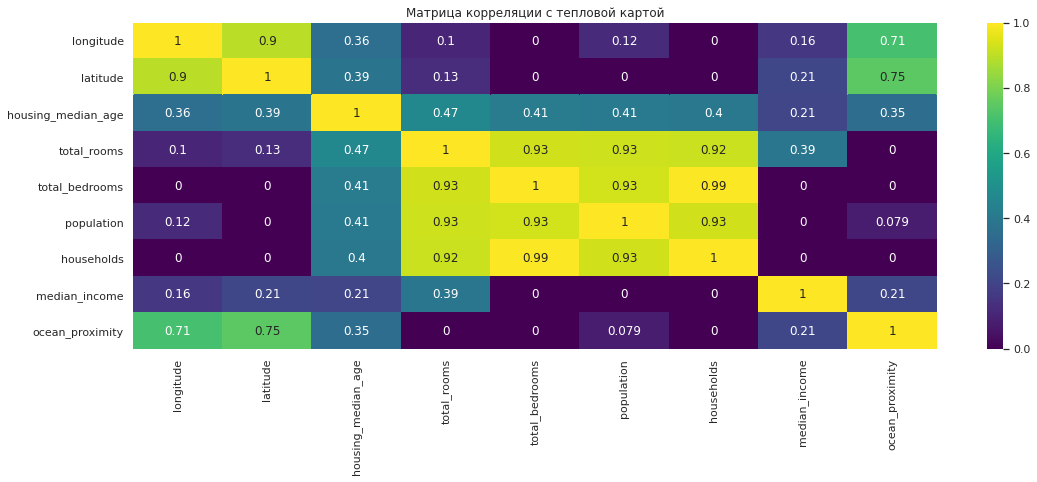

In [8]:
features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households",
    "median_income",
    ]

plt.figure(figsize = (18, 6))
sns.heatmap(
    df
    .sample(fraction=.04845, seed=RANDOM_SEED)
    .toPandas()
    .drop(["median_house_value"], axis=1)
    .phik_matrix(interval_cols=features),
    annot = True,
    cmap = 'viridis'
    )
plt.title('Матрица корреляции с тепловой картой')

plt.show()

Крайне высокая корреляция наблюдается между `total_bedrooms` и `households`, `total_rooms` и `total_bedrooms`, `total_rooms` и `households`, `longitude` и `latitude`.

Достатчоно враженая у `population` и `households`, `population` и `total_rooms`, `population` и `total_bedrooms`, `latitude` и `ocean_proximity`, `longitude` и `ocean_proximity`.

Средняя у `total_rooms` и `housing_median_age`, `longitude` и `housing_median_age`, `total_bedrooms` и `housing_median_age`, `latitude` и `housing_median_age`, `households` и `housing_median_age`, `ocean_proximity` и `housing_median_age`.

Влияние остальных параметров выржено слабо.

В рамках проекта нам нужно работать с моделями линейной регрессии, вопрос мультиколлинеарности становится особенно актуальным. Нам нужно провести преобразования, чтобы снизить мультиколлинеарность для этогоразбавим даннеы, создав дополнительные признаки.

In [9]:
df = df.withColumn(
    "average_rooms_per_household",
    F.col("total_rooms") / F.col("households")
    )
df = df.withColumn(
    "average_bedrooms_per_room",
    F.col("total_bedrooms") / F.col("total_rooms")
    )
df = df.withColumn(
    "average_size_of_a_household",
    F.col("population") / F.col("households")
    )

Рассмотрим новую корреляционную матрицу, в которой появились новые переменные, а некоторые из старых мы исключили из анализа.

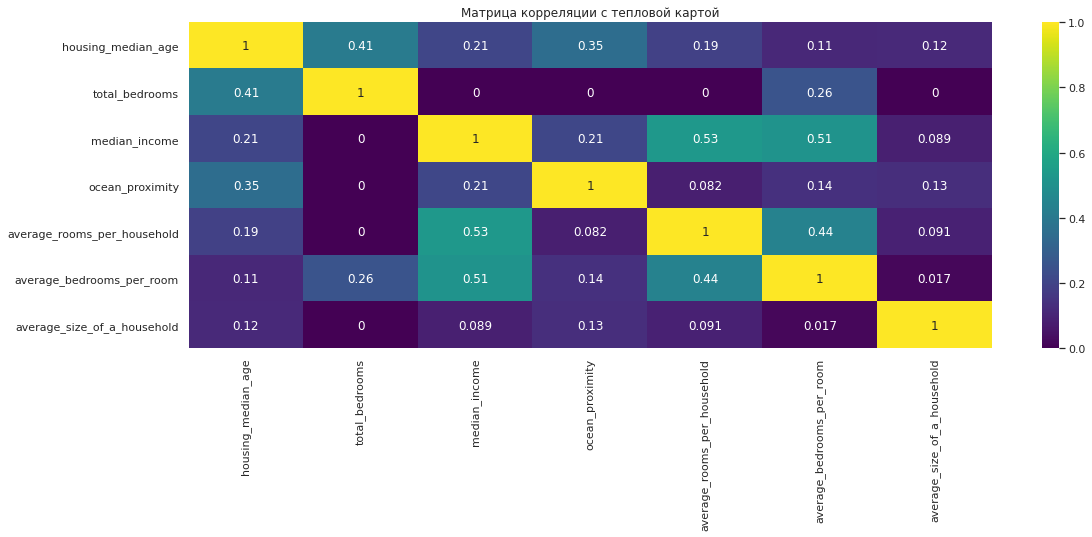

In [10]:
features = [
    "total_bedrooms",
    "housing_median_age",
    "average_rooms_per_household",
    "average_bedrooms_per_room",
    "average_size_of_a_household",
    "median_income",
]

plt.figure(figsize = (18, 6))
sns.heatmap(
    df
    .sample(fraction=.04845, seed=RANDOM_SEED)
    .toPandas()
    .drop([
            "longitude",
            "latitude",
            "total_rooms",
            "population",
            "households",
            "median_house_value"
        ], axis=1)
    .phik_matrix(interval_cols=features),
    annot = True,
    cmap = 'viridis'
    )
plt.title('Матрица корреляции с тепловой картой')

plt.show()

Матрица стала выглядеть занчительно лучше. зависимотьи распределились более равномерно и мы уверены в том наоборе параметров, с которым будем работать дальше.

Мы выпоонили необходимые имопрты, изучили данные. Мы обнаружили пробелы в данных, которые будем обрабатывать далее в работе. Затем мы рассмотрели гистограммы и диаграммы размаха признаков и решили не удалять выбросы т.к. они очень похожи на структру данных и естьсвенное поведение данных. После этого мы изучили корреляционную матрицу и обнаружили мультиколлинеарность, которую обработали, добавив новые  признаки.

## Обучение моделей

Сначала разделим наши данные на обучающую и тестовую выборки.

In [11]:
train_data, test_data = df.randomSplit([.75, .25], seed=RANDOM_SEED)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Здорово , что у нас есть выборка для тестов!</font>

Далее используем Pipeline для обработки данных, обучения моделей и получения прогнозов.

In [12]:
numerical_cols = [
    "housing_median_age",
    "total_bedrooms",
    "median_income",
    "average_rooms_per_household",
    "average_bedrooms_per_room",
    "average_size_of_a_household"
]
#Применим StringIndexer для трансформации текстовых данных в категориальном столбце ocean_proximity в числа
indexer = StringIndexer(
    inputCol="ocean_proximity",
    outputCol="ocean_proximity_idx",
    handleInvalid="keep"
)
#Произведем кодирование категориального признака.
#Поскольку мы имеем дело с единственным категориальным признаком, то у нас нет необходимости использовать VectorAssembler.
ohe = OneHotEncoder(
    inputCol=indexer.getOutputCol(),
    outputCol="ocean_proximity_ohe"
)
#Заполним пропуски в столбце total_bedrooms медианным значением
imputer = Imputer(
    inputCols=["total_bedrooms", "average_bedrooms_per_room"],
    outputCols=["total_bedrooms", "average_bedrooms_per_room"],
    strategy="median"
)
#Соберем числовые признаки
numerical_va = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="numerical_features"
)
#Масштабируем полученые вектора
scaler = StandardScaler(
    inputCol=numerical_va.getOutputCol(),
    outputCol="numerical_features_scaled"
)
#Соберем преобразованные признаки в единый вектор
final_va = VectorAssembler(
    inputCols=[ohe.getOutputCol(), scaler.getOutputCol()],
    outputCol="features"
)
#Обучим модель и получим предсказания на основании всех признаков.
lr1 = LinearRegression(
    labelCol="median_house_value",
    featuresCol=final_va.getOutputCol(),
    regParam=.1
)
#Обучим модель и получим предсказания на основании только числовых признаков
lr2 = LinearRegression(
    labelCol="median_house_value",
    featuresCol=numerical_va.getOutputCol(),
    regParam=.1
)

pipeline_1 = Pipeline(
    stages=[
        indexer,
        ohe,
        imputer,
        numerical_va,
        scaler,
        final_va,
        lr1
    ]
)
pipeline_2 = Pipeline(
    stages=[
        imputer,
        numerical_va,
        scaler,
        lr2
    ]
)

model_1 = pipeline_1.fit(train_data)
model_1_predictions = model_1.transform(test_data)

model_2 = pipeline_2.fit(train_data)
model_2_predictions = model_2.transform(test_data)

24/04/08 13:45:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/04/08 13:45:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/04/08 13:45:39 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/04/08 13:45:39 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


По привычному алгоритму разделили данные на тренировочные и тестовые, провели кодирование категориальных значений и масштабирование численных признаков, выполнили векторизацию наших данных и обучили две модели линейной регрессии,  согласно задаче.

## Анализ результатов

Выведем метрики для двух моделей и сравним их между собой.

In [13]:
models = ["model_1", "model_2"]
metrics = ["mae", "rmse", "r2"]
results = pd.DataFrame(index=models, columns=metrics)

for model in models:
    for metric in metrics:
        results.loc[model, metric] = RegressionEvaluator(
            labelCol="median_house_value",
            metricName=metric
        ).evaluate(locals().get(model + "_predictions")
                  )
results.style.format("{:.3f}")

,mae,rmse,r2
model_1,51342.929,70780.538,0.621
model_2,55939.633,75976.937,0.563


Первая модель линейной регрессии показывает лучшие результаты по всем трем показателям.

Закроем сессию по завершении проекта.

In [14]:
spark.stop()